## Imports

In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Bidirectional, Layer, Multiply, Permute, RepeatVector, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
from sklearn.metrics import accuracy_score

2025-07-29 17:02:49.008157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753808569.378984      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753808569.479776      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Configurations

In [ ]:
N_MODALITIES = 3
N_DAYS = 10
IMG_SIZE = (64, 64)
DATA_DIR = "/kaggle/input/data-3k/data_set_3K"
MAX_SAMPLES_PER_CLASS = {'0':200, '1':250}

## Data Loading


In [ ]:
def load_data(DATA_DIR, samples_per_class):
    X_raw, y = [], []
    for label, max_samples in samples_per_class.items():
        label_path = os.path.join(DATA_DIR, label)
        sample_folders = sorted(os.listdir(label_path))
        count = 0

        for sample_id in sample_folders:
            if count >= max_samples:
                break
            sample_path = os.path.join(label_path, sample_id)
            modalities = sorted(os.listdir(sample_path))[:N_MODALITIES]
            cube = []

            for mod in modalities:
                mod_path = os.path.join(sample_path, mod)
                day_images = []
                for d in range(1, N_DAYS + 1):
                    img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
                    if os.path.exists(img_path):
                        img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                        img_np = np.array(img)
                        day_images.append(img_np)
                if len(day_images) == N_DAYS:
                    cube.append(day_images)

            if len(cube) == N_MODALITIES:
                cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
                X_raw.append(cube_np)
                y.append(int(label))
                count += 1

    return np.array(X_raw), np.array(y)

## Attention Layer

In [ ]:
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.dense1 = Dense(1, activation='tanh')
        self.flatten = Flatten()
        self.softmax = Dense(N_DAYS, activation='softmax')
        self.repeat = RepeatVector(256)
        self.permute = Permute([2, 1])

    def call(self, inputs):
        attention_scores = self.dense1(inputs)
        attention_weights = self.flatten(attention_scores)
        attention_weights = self.softmax(attention_weights)
        attention_weights = self.repeat(attention_weights)
        attention_weights = self.permute(attention_weights)
        return Multiply()([inputs, attention_weights])

## Model Training

In [ ]:
def train_habnet(data_dir, samples_per_class):
    print('Starting to Load Data..........')
    X_raw, y = load_data(data_dir, samples_per_class)
    print("✅ Data shape:", X_raw.shape, y.shape)

    y_cat = to_categorical(y)

    X_train, X_val, y_train, y_val = train_test_split(X_raw, y_cat, test_size=0.2, random_state=42, shuffle = True)

    input_shape = (N_DAYS, IMG_SIZE[0], IMG_SIZE[1], N_MODALITIES)
    inputs = Input(shape=input_shape)

    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = AttentionLayer()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("🚀 Starting Tier 2 Training...")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    end = time.time()
    print("\n✅ Time taken:", round(end - start, 2), "seconds")

    print("\n📊 Evaluation on Test Set:")
    X_test, y_test = load_data('/kaggle/input/test-hab-200/Test_HAB_200', {'0':200, '1':200})

    print(" Data shape:", X_test.shape, y_test.shape)
    Y_test = to_categorical(y_test)
    
    loss, acc = model.evaluate(X_test, Y_test)
    print("Test Accuracy:", acc)

    pred = model.predict(X_test).argmax(axis=1)
    print('Pred Shape : ', pred.shape)
    print('Accuracy Score : ', accuracy_score(pred, y_test))
    print(classification_report(pred, y_test))
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Tier 2 Confusion Matrix")
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Tier 2 Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model

Starting to Load Data..........
✅ Data shape: (450, 10, 64, 64, 3) (450,)


I0000 00:00:1753808736.075066      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753808736.075896      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


🚀 Starting Tier 2 Training...
Epoch 1/50


I0000 00:00:1753808745.177183      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.5243 - loss: 0.6940 - val_accuracy: 0.5333 - val_loss: 0.6829
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5945 - loss: 0.6782 - val_accuracy: 0.5333 - val_loss: 0.6748
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5772 - loss: 0.6694 - val_accuracy: 0.5333 - val_loss: 0.6676
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5942 - loss: 0.6576 - val_accuracy: 0.5667 - val_loss: 0.6482
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6957 - loss: 0.6289 - val_accuracy: 0.6556 - val_loss: 0.6385
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7065 - loss: 0.6351 - val_accuracy: 0.6556 - val_loss: 0.6204
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6938 - loss: 0.5963 - val_accuracy: 0.7111 - val_loss: 0.5844
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7657 - loss: 0.5517 - val_accuracy: 0.8333 - val_loss: 

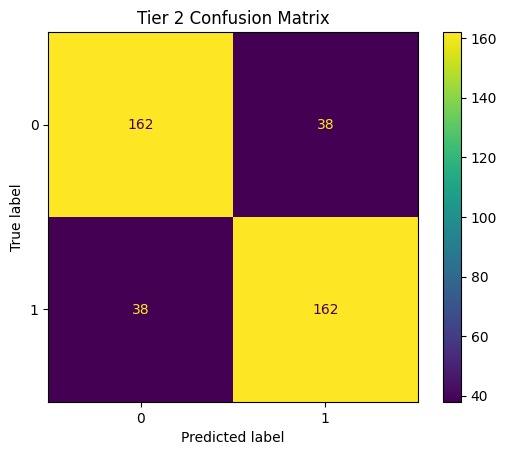

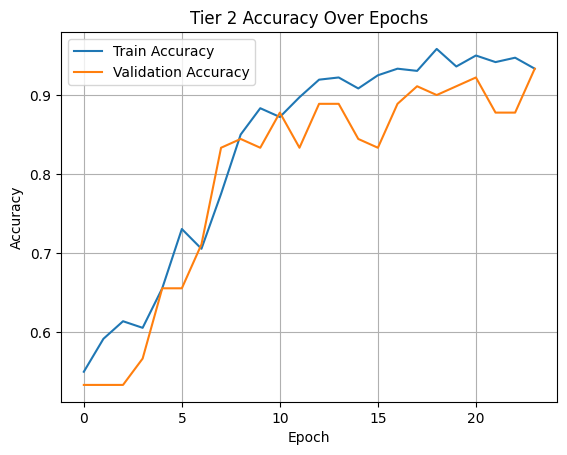

In [6]:
model = train_habnet(DATA_DIR, MAX_SAMPLES_PER_CLASS)

## Testing on unseen data

In [7]:
test_X, test_y = load_data('/kaggle/input/test-hab-200/Test_HAB_200', {'0':200, '1':200})

In [8]:
p = np.random.permutation(len(test_X))
X_test_shuffled = test_X[p]
y_test_shuffled = test_y[p]

In [9]:
test_X.shape, test_y.shape, X_test_shuffled.shape, y_test_shuffled.shape

((400, 10, 64, 64, 3), (400,), (400, 10, 64, 64, 3), (400,))

In [10]:
preds = model.predict(X_test_shuffled)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


              precision    recall  f1-score   support

           0       0.81      0.81      0.81       200
           1       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



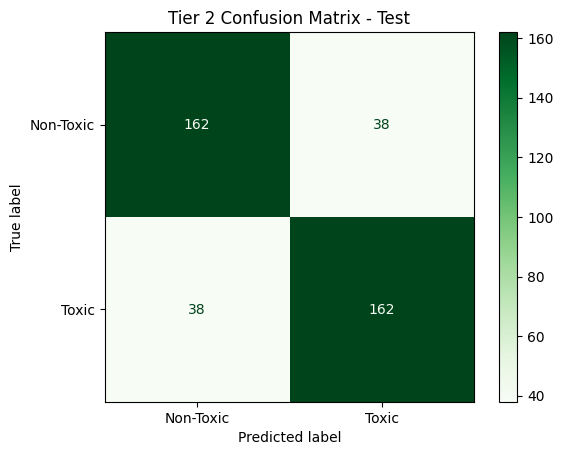

In [ ]:
print(classification_report(y_test_shuffled, preds)
ConfusionMatrixDisplay.from_predictions(y_test_shuffled, preds, display_labels=["Non-Toxic", "Toxic"], cmap="Greens")
plt.title("Tier 2 Confusion Matrix - Test")
plt.show()

## Testing with single datacube

In [17]:
def load_datacube(sample_path):
    modalities = sorted(os.listdir(sample_path))[:N_MODALITIES]
    cube = []

    for mod in modalities:
        mod_path = os.path.join(sample_path, mod)
        day_images = []
        for d in range(1, N_DAYS + 1):
            img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                img_np = np.array(img)
                day_images.append(img_np)
        if len(day_images) == N_DAYS:
            cube.append(day_images)

    if len(cube) == N_MODALITIES:
        cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
        x = cube_np
    return x

In [18]:
def predict_datacube(folder_path, model):
    x = load_datacube(folder_path)
    print(model.predict(np.expand_dims(x,0)))

In [19]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/0/habnet_datacube_20160404_26.7614_-82.0611_0', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[[0.6295083  0.37049168]]


In [20]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/0/habnet_datacube_20160321_27.311_-82.5772_0', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.97697484 0.02302518]]


In [21]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161003_27.5298_-82.704_250667', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.05762123 0.94237876]]


In [22]:
predict_datacube('/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161007_27.3316_-82.5779_516000', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.20862839 0.79137164]]


## Model Summary

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 30752)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │    31,622,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 10, 256)        │           367 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,854,421 (365.66 MB)

 Trainable params: 31,951,473 (121.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,902,948 (243.77 MB)

## Saving Model

In [24]:
model.save('Teir-2_model.h5')